### INSTALL DEPENDENCIES

In [ ]:
%%capture
!pip install --upgrade sentence-transformers datasets accelerate torch transformers

### IMPORT LIBRARIES

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import json
import torch
from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    losses,
)
from sentence_transformers.util import cos_sim
from sentence_transformers.evaluation import InformationRetrievalEvaluator, SequentialEvaluator
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.losses import MatryoshkaLoss

### CONFIGURATIONS

In [ ]:
DATA_PATH = "./final_mixed_train.jsonl"
MODEL_ID = "ibm-granite/granite-embedding-english-r2"
OUTPUT_DIR = "./embedding"

MATRYOSHKA_DIMS = [768, 512, 256, 128, 64]

# List of metrics to display
metrics = [
    'ndcg@10',
    'mrr@10',
    'map@100',
    'accuracy@1',
    'accuracy@3',
    'accuracy@5',
    'accuracy@10',
    'precision@1',
    'precision@3',
    'precision@5',
    'precision@10',
    'recall@1',
    'recall@3',
    'recall@5',
    'recall@10'
]

### DATA LOADING & PREPARATION

In [ ]:
data_rows = []

try:
  with open(DATA_PATH, 'r', encoding='utf-8') as f:
    for idx, line in enumerate(f):
      try:
        row = json.loads(line)
        question = row.get('instruction', '').strip()
        answer = row.get('output', '').strip()
        context = row.get('input', '').strip()

        # Combine context
        positive_text = f"Context: {context}\nAnswer: {answer}"

        # Convert ID to string (Must follow this order)
        data_rows.append({
          "anchor": question,
          "positive": positive_text,
          "id": str(idx),
        })

      except json.JSONDecodeError:
        continue
except FileNotFoundError:
    print(f"ERROR: Could not find {DATA_PATH}. Please upload it to Colab.")

# Convert to HF dataset
full_dataset = Dataset.from_list(data_rows)

# Split dataset
dataset_dict = full_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset_dict["train"]
test_dataset = dataset_dict["test"]

### MODEL & LOSS SETUP

In [ ]:
model = SentenceTransformer(MODEL_ID, device="cuda" if torch.cuda.is_available() else "cpu")
model.max_seq_length = 512

# Inner Loss: MNRL
inner_loss = losses.MultipleNegativesRankingLoss(model)

# Outer Loss: Matryoshka
train_loss = MatryoshkaLoss(
    model=model,
    loss=inner_loss,
    matryoshka_dims=MATRYOSHKA_DIMS
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### EVALUATION SETUP

In [ ]:
# Extract lists for evaluation from the Test set
corpus = {row["id"]: row["positive"] for row in test_dataset}
queries = {row["id"]: row["anchor"] for row in test_dataset}
relevant_docs = {row["id"]: {row["id"]} for row in test_dataset}

# Create a list of evaluators
evaluators_list = []
for dim in MATRYOSHKA_DIMS:
   # Define the evaluator
    ir_evaluator = InformationRetrievalEvaluator(
        queries=queries,
        corpus=corpus,
        relevant_docs=relevant_docs,
        name=f"dim_{dim}",
        truncate_dim=dim,  # Truncate the embeddings to the respective dimension
        score_functions={"cosine": cos_sim},
    )
    # Add to list
    evaluators_list.append(ir_evaluator)

# Combine into one Sequential Evaluator
seq_evaluator = SequentialEvaluator(evaluators_list)

### EVALUATE BEFORE TRAINING

In [ ]:
# Evaluate the model
base_results = seq_evaluator(model)

# Print header
print("\nBase Model Evaluation Results")
print("-" * 85)
print(f"{'Metric':15} {'768d':>12} {'512d':>12} {'256d':>12} {'128d':>12} {'64d':>12}")
print("-" * 85)

# Print each metric
for metric in metrics:
    values = []
    for dim in MATRYOSHKA_DIMS:
        key = f"dim_{dim}_cosine_{metric}"
        values.append(base_results[key])

    # Highlight NDCG@10
    metric_name = f"=={metric}==" if metric == "ndcg@10" else metric
    print(f"{metric_name:15}", end="  ")
    for val in values:
        print(f"{val:12.4f}", end=" ")
    print()

# Print sequential score
print("-" * 85)
print(f"{'seq_score:'} {base_results['sequential_score']:1f}")

/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:312: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(



Base Model Evaluation Results
-------------------------------------------------------------------------------------
Metric                  768d         512d         256d         128d          64d
-------------------------------------------------------------------------------------
==ndcg@10==            0.6227       0.6213       0.6163       0.6036       0.5905 
mrr@10                 0.6109       0.6086       0.6045       0.5941       0.5809 
map@100                0.6160       0.6139       0.6095       0.5986       0.5856 
accuracy@1             0.5880       0.5860       0.5820       0.5760       0.5580 
accuracy@3             0.6300       0.6200       0.6200       0.6100       0.6040 
accuracy@5             0.6420       0.6420       0.6300       0.6160       0.6100 
accuracy@10            0.6600       0.6620       0.6540       0.6340       0.6200 
precision@1            0.5880       0.5860       0.5820       0.5760       0.5580 
precision@3            0.2100       0.2067       0.2

### TRAINING

In [ ]:
# Training Arguments
args = SentenceTransformerTrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=20,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    warmup_ratio=0.1,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    optim="adamw_torch_fused",
    fp16=False,
    bf16=True,
    tf32=True,
    batch_sampler=BatchSamplers.NO_DUPLICATES,
    dataloader_num_workers=4,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_dim_768_cosine_ndcg@10",       # Optimizing for the best ndcg@10 for full dimension
    report_to="none"
)

In [ ]:
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    loss=train_loss,
    evaluator=seq_evaluator,
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [ ]:
torch.cuda.empty_cache()
trainer.train()

trainer.save_model()
model.save_pretrained(OUTPUT_DIR)

Epoch,Training Loss,Validation Loss,Dim 768 Cosine Accuracy@1,Dim 768 Cosine Accuracy@3,Dim 768 Cosine Accuracy@5,Dim 768 Cosine Accuracy@10,Dim 768 Cosine Precision@1,Dim 768 Cosine Precision@3,Dim 768 Cosine Precision@5,Dim 768 Cosine Precision@10,Dim 768 Cosine Recall@1,Dim 768 Cosine Recall@3,Dim 768 Cosine Recall@5,Dim 768 Cosine Recall@10,Dim 768 Cosine Ndcg@10,Dim 768 Cosine Mrr@10,Dim 768 Cosine Map@100,Dim 512 Cosine Accuracy@1,Dim 512 Cosine Accuracy@3,Dim 512 Cosine Accuracy@5,Dim 512 Cosine Accuracy@10,Dim 512 Cosine Precision@1,Dim 512 Cosine Precision@3,Dim 512 Cosine Precision@5,Dim 512 Cosine Precision@10,Dim 512 Cosine Recall@1,Dim 512 Cosine Recall@3,Dim 512 Cosine Recall@5,Dim 512 Cosine Recall@10,Dim 512 Cosine Ndcg@10,Dim 512 Cosine Mrr@10,Dim 512 Cosine Map@100,Dim 256 Cosine Accuracy@1,Dim 256 Cosine Accuracy@3,Dim 256 Cosine Accuracy@5,Dim 256 Cosine Accuracy@10,Dim 256 Cosine Precision@1,Dim 256 Cosine Precision@3,Dim 256 Cosine Precision@5,Dim 256 Cosine Precision@10,Dim 256 Cosine Recall@1,Dim 256 Cosine Recall@3,Dim 256 Cosine Recall@5,Dim 256 Cosine Recall@10,Dim 256 Cosine Ndcg@10,Dim 256 Cosine Mrr@10,Dim 256 Cosine Map@100,Dim 128 Cosine Accuracy@1,Dim 128 Cosine Accuracy@3,Dim 128 Cosine Accuracy@5,Dim 128 Cosine Accuracy@10,Dim 128 Cosine Precision@1,Dim 128 Cosine Precision@3,Dim 128 Cosine Precision@5,Dim 128 Cosine Precision@10,Dim 128 Cosine Recall@1,Dim 128 Cosine Recall@3,Dim 128 Cosine Recall@5,Dim 128 Cosine Recall@10,Dim 128 Cosine Ndcg@10,Dim 128 Cosine Mrr@10,Dim 128 Cosine Map@100,Dim 64 Cosine Accuracy@1,Dim 64 Cosine Accuracy@3,Dim 64 Cosine Accuracy@5,Dim 64 Cosine Accuracy@10,Dim 64 Cosine Precision@1,Dim 64 Cosine Precision@3,Dim 64 Cosine Precision@5,Dim 64 Cosine Precision@10,Dim 64 Cosine Recall@1,Dim 64 Cosine Recall@3,Dim 64 Cosine Recall@5,Dim 64 Cosine Recall@10,Dim 64 Cosine Ndcg@10,Dim 64 Cosine Mrr@10,Dim 64 Cosine Map@100,Sequential Score
1,7.795200,No log,0.588000,0.646000,0.658000,0.676000,0.588000,0.215333,0.131600,0.067600,0.588000,0.646000,0.658000,0.676000,0.632194,0.618133,0.624147,0.586000,0.640000,0.654000,0.676000,0.586000,0.213333,0.130800,0.067600,0.586000,0.640000,0.654000,0.676000,0.630383,0.615848,0.622204,0.588000,0.634000,0.644000,0.670000,0.588000,0.211333,0.128800,0.067000,0.588000,0.634000,0.644000,0.670000,0.628137,0.614860,0.621852,0.592000,0.636000,0.650000,0.668000,0.592000,0.212000,0.130000,0.066800,0.592000,0.636000,0.650000,0.668000,0.629054,0.616621,0.623404,0.578000,0.632000,0.646000,0.664000,0.578000,0.210667,0.129200,0.066400,0.578000,0.632000,0.646000,0.664000,0.621832,0.608229,0.614830,0.621832
2,5.449800,No log,0.602000,0.652000,0.682000,0.700000,0.602000,0.217333,0.136400,0.070000,0.602000,0.652000,0.682000,0.700000,0.649432,0.633330,0.640819,0.604000,0.648000,0.674000,0.708000,0.604000,0.216000,0.134800,0.070800,0.604000,0.648000,0.674000,0.708000,0.650605,0.632829,0.640067,0.598000,0.650000,0.674000,0.702000,0.598000,0.216667,0.134800,0.070200,0.598000,0.650000,0.674000,0.702000,0.647643,0.630547,0.638315,0.604000,0.662000,0.676000,0.708000,0.604000,0.220667,0.135200,0.070800,0.604000,0.662000,0.676000,0.708000,0.654682,0.637888,0.644996,0.602000,0.658000,0.676000,0.698000,0.602000,0.219333,0.135200,0.069800,0.602000,0.658000,0.676000,0.698000,0.649162,0.633629,0.641429,0.649162
3,4.285700,No log,0.618000,0.674000,0.694000,0.718000,0.618000,0.224667,0.138800,0.071800,0.618000,0.674000,0.694000,0.718000,0.667034,0.650832,0.658851,0.610000,0.664000,0.682000,0.726000,0.610000,0.221333,0.136400,0.072600,0.610000,0.664000,0.682000,0.726000,0.663560,0.644281,0.652352,0.618000,0.674000,0.692000,0.732000,0.618000,0.224667,0.138400,0.073200,0.618000,0.674000,0.692000,0.732000,0.671337,0.652531,0.660000,0.616000,0.672000,0.690000,0.724000,0.616000,0.224000,0.138000,0.072400,0.616000,0.672000,0.690000,0.724000,0.667328,0.649560,0.656448,0.598000,0.664000,0.694000,0.730000,0.598000,0.221333,0.138800,0.073000,0.598000,0.664000,0.694000,0.7300

### EVALUATE AFTER TRAINING

In [ ]:
fine_tuned_model = SentenceTransformer(
    args.output_dir, device="cuda" if torch.cuda.is_available() else "cpu"
)

# Evaluate the model
ft_results = seq_evaluator(fine_tuned_model)

# Print header
print("Fine Tuned Model Evaluation Results")
print("-" * 85)
print(f"{'Metric':15} {'768d':>12} {'512d':>12} {'256d':>12} {'128d':>12} {'64d':>12}")
print("-" * 85)

# Print each metric
for metric in metrics:
    values = []
    for dim in MATRYOSHKA_DIMS:
        key = f"dim_{dim}_cosine_{metric}"
        values.append(ft_results[key])

    # Highlight NDCG@10
    metric_name = f"=={metric}==" if metric == "ndcg@10" else metric
    print(f"{metric_name:15}", end="  ")
    for val in values:
        print(f"{val:12.4f}", end=" ")
    print()

# Print sequential score
print("-" * 85)
print(f"{'seq_score:'} {ft_results['sequential_score']:1f}")

Fine Tuned Model Evaluation Results
-------------------------------------------------------------------------------------
Metric                  768d         512d         256d         128d          64d
-------------------------------------------------------------------------------------
==ndcg@10==            0.6986       0.6981       0.7001       0.6868       0.6807 
mrr@10                 0.6820       0.6803       0.6834       0.6702       0.6655 
map@100                0.6870       0.6845       0.6868       0.6744       0.6697 
accuracy@1             0.6460       0.6440       0.6480       0.6340       0.6320 
accuracy@3             0.7100       0.7100       0.7120       0.7000       0.6940 
accuracy@5             0.7320       0.7300       0.7320       0.7220       0.7060 
accuracy@10            0.7500       0.7540       0.7520       0.7380       0.7280 
precision@1            0.6460       0.6440       0.6480       0.6340       0.6320 
precision@3            0.2367       0.2367     

### COMPARE RESULTS

In [ ]:
print("\nImpact Analysis: Base vs Fine-Tuned (NDCG@10)")
print("=" * 70)
print(f"{'Dimension':<10} {'Base':<10} {'Fine-Tuned':<12} {'Diff':<10} {'% Gain':<10}")
print("-" * 70)

target_metric = "ndcg@10"

# Loop through the dimensions defined in your notebook (MATRYOSHKA_DIMS)
for dim in MATRYOSHKA_DIMS:
    # Construct the dictionary key
    key = f"dim_{dim}_cosine_{target_metric}"

    base_score = base_results.get(key, 0)
    ft_score = ft_results.get(key, 0)

    diff = ft_score - base_score
    pct_gain = (diff / base_score) * 100 if base_score > 0 else 0

    # Print row with conditional formatting for positive gains
    gain_str = f"{pct_gain:+.2f}%"
    print(f"{dim:<10} {base_score:.4f}     {ft_score:.4f}       {diff:+.4f}     {gain_str:<10}")

print("=" * 70)


Impact Analysis: Base vs Fine-Tuned (NDCG@10)
Dimension  Base       Fine-Tuned   Diff       % Gain    
----------------------------------------------------------------------
768        0.6227     0.6986       +0.0759     +12.19%   
512        0.6213     0.6981       +0.0768     +12.36%   
256        0.6163     0.7001       +0.0839     +13.61%   
128        0.6036     0.6868       +0.0831     +13.78%   
64         0.5905     0.6807       +0.0902     +15.27%   


In [ ]:
print("Comprehensive Impact Analysis: Base vs Fine-Tuned")
print("=" * 80)

# Iterate through every metric defined in your 'metrics' list
for metric in metrics:
    print(f"\n- {metric.upper()}")
    print("-" * 65)
    print(f"{'Dimension':<10} {'Base':<10} {'Fine-Tuned':<12} {'Diff':<10} {'% Gain':<10}")
    print("-" * 65)

    # Loop through dimensions for this specific metric
    for dim in MATRYOSHKA_DIMS:
        # Construct key
        key = f"dim_{dim}_cosine_{metric}"

        base_score = base_results.get(key, 0)
        ft_score = ft_results.get(key, 0)

        diff = ft_score - base_score

        # Avoid division by zero
        if base_score > 0:
            pct_gain = (diff / base_score) * 100
        else:
            pct_gain = 0.0

        # Conditional formatting for the gain column
        gain_str = f"{pct_gain:+.2f}%"

        print(f"{dim:<10} {base_score:.4f}     {ft_score:.4f}       {diff:+.4f}     {gain_str:<10}")

    print("-" * 65)

print("\n" + "=" * 80)

Comprehensive Impact Analysis: Base vs Fine-Tuned

- NDCG@10
-----------------------------------------------------------------
Dimension  Base       Fine-Tuned   Diff       % Gain    
-----------------------------------------------------------------
768        0.6227     0.6986       +0.0759     +12.19%   
512        0.6213     0.6981       +0.0768     +12.36%   
256        0.6163     0.7001       +0.0839     +13.61%   
128        0.6036     0.6868       +0.0831     +13.78%   
64         0.5905     0.6807       +0.0902     +15.27%   
-----------------------------------------------------------------

- MRR@10
-----------------------------------------------------------------
Dimension  Base       Fine-Tuned   Diff       % Gain    
-----------------------------------------------------------------
768        0.6109     0.6820       +0.0711     +11.64%   
512        0.6086     0.6803       +0.0717     +11.77%   
256        0.6045     0.6834       +0.0790     +13.06%   
128        0.5941    

### GRAPH THE DIFFERENCE

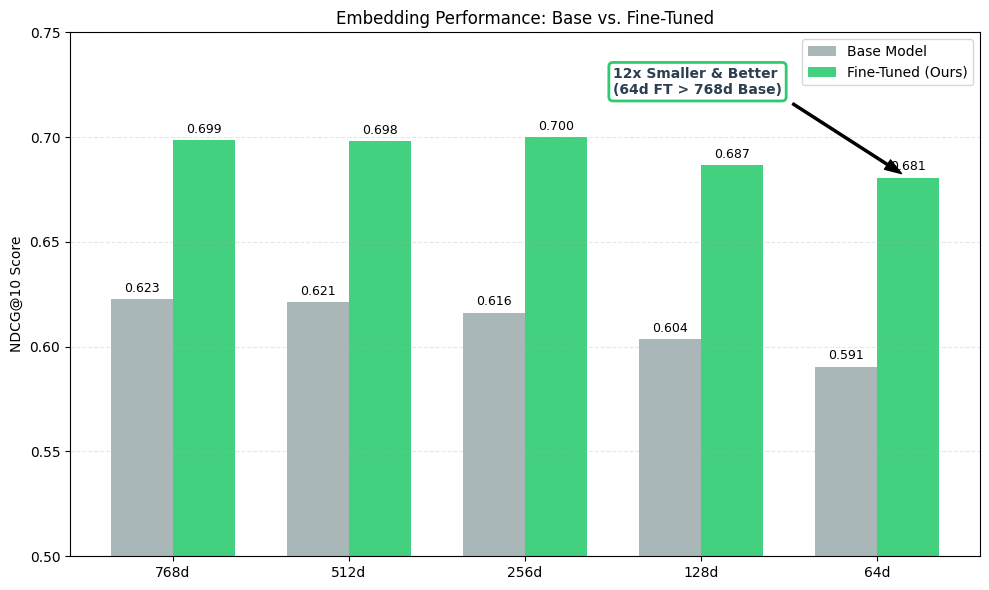

In [18]:
# --- 1. Dynamic Data Extraction ---
target_metric = "ndcg@10"
dims = []
base_scores = []
ft_scores = []

# Populate lists dynamically using your existing variables
for dim in MATRYOSHKA_DIMS:
    dims.append(f"{dim}d")

    key = f"dim_{dim}_cosine_{target_metric}"
    base_scores.append(base_results.get(key, 0))
    ft_scores.append(ft_results.get(key, 0))

# --- 2. Plotting Setup ---
x = np.arange(len(dims))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Plot Bars
rects1 = ax.bar(x - width/2, base_scores, width, label='Base Model', color='#95a5a6', alpha=0.8)
rects2 = ax.bar(x + width/2, ft_scores, width, label='Fine-Tuned (Ours)', color='#2ecc71', alpha=0.9)

# Styling
ax.set_ylabel(f'{target_metric.upper()} Score')
ax.set_title('Embedding Performance: Base vs. Fine-Tuned')
ax.set_xticks(x)
ax.set_xticklabels(dims)
ax.set_ylim(0.5, 0.75)
ax.legend(loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.3)

# --- 3. Dynamic Annotation (64d FT > 768d Base) ---
try:
    # Find the index of 64 dimensions to place the arrow correctly
    idx = MATRYOSHKA_DIMS.index(64)
    val_ft = ft_scores[idx]

    ax.annotate(
        '12x Smaller & Better\n(64d FT > 768d Base)',
        xy=(idx + width/2, val_ft),
        xytext=(idx - 1.5, val_ft + 0.04), # Dynamic text positioning
        arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
        fontsize=10,
        fontweight='bold',
        color='#2c3e50',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#2ecc71", lw=2)
    )
except ValueError:
    pass # Handle case if 64 is not in the list

# --- 4. Add Value Labels ---
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('embedding_benchmark.png')
plt.show()

### UPLOAD TO HUGGINGFACE

In [19]:
from huggingface_hub import login, HfApi

login()

trainer.model.push_to_hub("shatonix/granite-embedding-math-cs")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...s5p1bri/model.safetensors:   7%|7         | 41.9MB /  596MB            

'https://huggingface.co/shatonix/granite-embedding-math-cs/commit/e375da904c70a285c2d47facdbfd130592e963d4'